In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
# %reload lib.plotting 
from lib import plotting as p
from lib import dataprep as dp
import random
import umap
from tqdm import tqdm
from lib.evaluation import FeatureExtractor
# from lib.dataloader import CustomTestDataset
from lib.dataloader import CustomDataset
import tifffile as tiff
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import os
from boilerplate import boilerplate
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

In [22]:
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/"
keys = ['high_c1', 'high_c2', 'high_c3']
patch_size = 64
mask_size = 5
label_size = 1

# train data
train_img_paths = [os.path.join(data_dir, "train/", img, f"{img}_source.tif") for img in keys]
train_lbl_paths = [os.path.join(data_dir, "train/", img, f"{img}_gt.tif") for img in keys]
train_images = {img: tiff.imread(path) for img, path in zip(keys, train_img_paths)}
train_labels = {img: tiff.imread(path) for img, path in zip(keys, train_lbl_paths)}
#val data
val_img_paths = [os.path.join(data_dir, "val/", img, f"{img}_source.tif") for img in keys]
val_lbl_paths = [os.path.join(data_dir, "val/", img, f"{img}_gt.tif") for img in keys]
val_images = {img: tiff.imread(path) for img, path in zip(keys, val_img_paths)}
val_labels = {img: tiff.imread(path) for img, path in zip(keys, val_lbl_paths)}


for key in tqdm(keys, desc='Filtering data'):
   train_images[key], train_labels[key] = boilerplate._filter_slices(train_images[key], train_labels[key])
   val_images[key], val_labels[key] = boilerplate._filter_slices(val_images[key], val_labels[key])
   

train_set = CustomDataset(train_images, train_labels, patch_size, mask_size, label_size)
val_set = CustomDataset(val_images, val_labels, patch_size, mask_size, label_size)

Filtering data: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
Extracting patches from high_c1: 965it [00:02, 324.91it/s]
Extracting patches from high_c2: 889it [00:02, 321.29it/s]
Extracting patches from high_c3: 907it [00:02, 410.82it/s]
Extracting patches from high_c1: 109it [00:00, 121.65it/s]
Extracting patches from high_c2: 101it [00:00, 432.01it/s]
Extracting patches from high_c3: 103it [00:00, 385.66it/s]


In [23]:
print(f"Uncategorized: {len(train_set.patches_by_label[0])} Nucleus: {len(train_set.patches_by_label[1])} Granule: {len(train_set.patches_by_label[2])} Mitochondria: {len(train_set.patches_by_label[3])}")

Uncategorized: 84693 Nucleus: 18816 Granule: 32293 Mitochondria: 11368


In [24]:
print(f"Uncategorized: {len(val_set.patches_by_label[0])} Nucleus: {len(val_set.patches_by_label[1])} Granule: {len(val_set.patches_by_label[2])} Mitochondria: {len(val_set.patches_by_label[3])}")

Uncategorized: 9748 Nucleus: 1943 Granule: 3839 Mitochondria: 1313


5x5 <br>
Uncategorized: 60827 Nucleus: 18054 Granule: 17870 Mitochondria: 7438 <br>
Uncategorized: 6980 Nucleus: 1853 Granule: 2109 Mitochondria: 882

5x5 - 3x3 OR 3x3 <br>
Uncategorized: 72213 Nucleus: 18462 Granule: 24558 Mitochondria: 9355 <br>
Uncategorized: 8314 Nucleus: 1901 Granule: 2885 Mitochondria: 1090

5x5 - 1x1 OR 3x3 - 1x1 OR 1x1<br>
Uncategorized: 84693 Nucleus: 18816 Granule: 32293 Mitochondria: 11368 <br>
Uncategorized: 9748 Nucleus: 1943 Granule: 3839 Mitochondria: 1313

tensor(0, dtype=torch.int8)


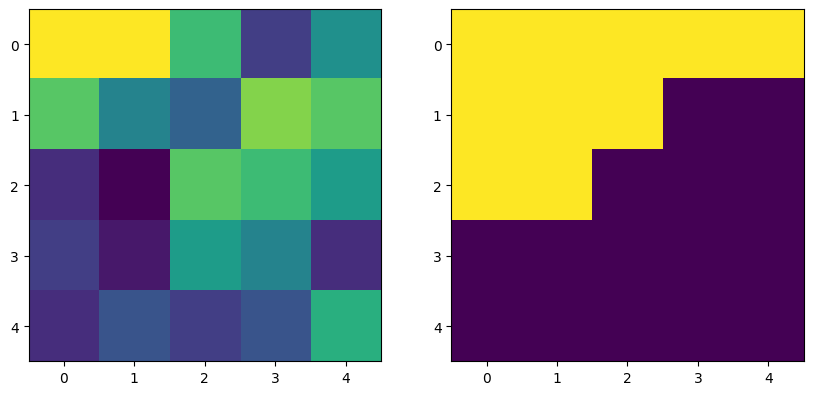

In [29]:
img, cls, lbl = train_set.all_patches[train_set.patches_by_label[0][103]]
print(cls)
start =  (patch_size - mask_size) // 2
img = img.squeeze(0)
lbl = lbl.squeeze(0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[start:start+mask_size, start:start+mask_size])
ax[1].imshow(lbl[start:start+mask_size, start:start+mask_size])

In [8]:
def save_percent(file_path, data):
    with open(file_path, 'wb') as file:
        # Serialize and write the variable to the file
        pickle.dump(data, file)

In [6]:
import random

categories = ['uncategorized', 'nucleus', 'granule', 'mitochondria']
percent = ['1', '10']
modes = ['5x5', '5x5_3x3', '5x5_1x1', '3x3', '3x3_1x1', '1x1']

for i in range(len(modes)):
    mask_size = modes[i][0]
    label_size = modes[i][-1]
    train_set = CustomDataset(train_images, train_labels, patch_size, mask_size, label_size)
    val_set = CustomDataset(val_images, val_labels, patch_size, mask_size, label_size)

l0 = random.sample(train_set.patches_by_label[0], 6082)
l1 = random.sample(train_set.patches_by_label[1], 1805)
l2 = random.sample(train_set.patches_by_label[2], 1787)
l3 = random.sample(train_set.patches_by_label[3], 743)


save_percent(data_dir+'train/5x5/10_percent_uncategorized.pickle',l0)
save_percent(data_dir+'train/5x5/10_percent_nucleus.pickle',l1)
save_percent(data_dir+'train/5x5/10_percent_granule.pickle',l2)
save_percent(data_dir+'train/5x5/10_percent_mitochondria.pickle',l3)

save_percent(data_dir+'val/5x5/10_percent_uncategorized.pickle',random.sample(val_set.patches_by_label[0], 698))
save_percent(data_dir+'val/5x5/10_percent_nucleus.pickle',random.sample(val_set.patches_by_label[1], 185))
save_percent(data_dir+'val/5x5/10_percent_granule.pickle',random.sample(val_set.patches_by_label[2], 210))
save_percent(data_dir+'val/5x5/10_percent_mitochondria.pickle',random.sample(val_set.patches_by_label[3], 88))

save_percent(data_dir+'train/5x5/1_percent_uncategorized.pickle',random.sample(train_set.patches_by_label[0], 608))
save_percent(data_dir+'train/5x5/1_percent_nucleus.pickle',random.sample(train_set.patches_by_label[1], 180))
save_percent(data_dir+'train/5x5/1_percent_granule.pickle',random.sample(train_set.patches_by_label[2], 178))
save_percent(data_dir+'train/5x5/1_percent_mitochondria.pickle',random.sample(train_set.patches_by_label[3], 74))

save_percent(data_dir+'val/5x5/1_percent_uncategorized.pickle',random.sample(val_set.patches_by_label[0], 69))
save_percent(data_dir+'val/5x5/1_percent_nucleus.pickle',random.sample(val_set.patches_by_label[1], 18))
save_percent(data_dir+'val/5x5/1_percent_granule.pickle',random.sample(val_set.patches_by_label[2], 21))
save_percent(data_dir+'val/5x5/1_percent_mitochondria.pickle',random.sample(val_set.patches_by_label[3], 8))


In [ ]:
import random
save_percent(data_dir+'train/5x5_3x3/10_percent_uncategorized.pickle',random.sample(train_set.patches_by_label[0], 6082))
save_percent(data_dir+'train/5x5_3x3/10_percent_nucleus.pickle',random.sample(train_set.patches_by_label[1], 1805))
save_percent(data_dir+'train/5x5_3x3/10_percent_granule.pickle',random.sample(train_set.patches_by_label[2], 1787))
save_percent(data_dir+'train/5x5_3x3/10_percent_mitochondria.pickle',random.sample(train_set.patches_by_label[3], 743))

save_percent(data_dir+'val/5x5_3x3/10_percent_uncategorized.pickle',random.sample(val_set.patches_by_label[0], 698))
save_percent(data_dir+'val/5x5_3x3/10_percent_nucleus.pickle',random.sample(val_set.patches_by_label[1], 185))
save_percent(data_dir+'val/5x5_3x3/10_percent_granule.pickle',random.sample(val_set.patches_by_label[2], 210))
save_percent(data_dir+'val/5x5_3x3/10_percent_mitochondria.pickle',random.sample(val_set.patches_by_label[3], 88))

save_percent(data_dir+'train/5x5_3x3/1_percent_uncategorized.pickle',random.sample(train_set.patches_by_label[0], 608))
save_percent(data_dir+'train/5x5_3x3/1_percent_nucleus.pickle',random.sample(train_set.patches_by_label[1], 180))
save_percent(data_dir+'train/5x5_3x3/1_percent_granule.pickle',random.sample(train_set.patches_by_label[2], 178))
save_percent(data_dir+'train/5x5_3x3/1_percent_mitochondria.pickle',random.sample(train_set.patches_by_label[3], 74))

save_percent(data_dir+'val/5x5_3x3/1_percent_uncategorized.pickle',random.sample(val_set.patches_by_label[0], 69))
save_percent(data_dir+'val/5x5_3x3/1_percent_nucleus.pickle',random.sample(val_set.patches_by_label[1], 18))
save_percent(data_dir+'val/5x5_3x3/1_percent_granule.pickle',random.sample(val_set.patches_by_label[2], 21))
save_percent(data_dir+'val/5x5_3x3/1_percent_mitochondria.pickle',random.sample(val_set.patches_by_label[3], 8))
